In [10]:
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub


In [11]:
from tools import get_Tapes, read_merged_data
import pandas as pd
raw_tapes = get_Tapes(125,0)
tapes_data = [t["Price"].resample("1min").last().ffill().to_numpy() for t in raw_tapes] # resample down to 1 min

merged_data = read_merged_data(124)
merged_df = pd.concat(merged_data, axis = 0)
merged_df.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Data\\Tapes'

In [101]:
# get test data
import matplotlib.pyplot as plt
import numpy as np
from numba import njit


# define broker

def broker(actor, price_data: np.array, starting_cash: int, commission = 0.001, stock_start = 0.5):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    num_stocks[0] = starting_cash // (price_data[0] * 2)
    cash_value[0] = starting_cash - num_stocks[0] * price_data[0]

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        while abs(action) > 0:
            if action > 0: # buy stock
                if cash_value[time_index] >= price_data[time_index]:
                    cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                    cash_value[time_index] = cash_value[time_index] - price_data[time_index] * commission # add commission
                    num_stocks[time_index] = num_stocks[time_index] + 1

                action += -1

            else: # sell stock
                if num_stocks[time_index] > 0:
                    num_stocks[time_index] = num_stocks[time_index] - 1
                    cash_value[time_index] = cash_value[time_index] + price_data[time_index]
                    cash_value[time_index] = cash_value[time_index] - price_data[time_index] * commission # add commission

                action += 1

        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value
    profit = (total_value[-1] / starting_cash) - 1
    
    return num_stocks, cash_value, total_value, profit

# generate folds
def generate_folds(tapes_data, n_folds=5):
    tapes_data = np.array(tapes_data)
    fold_size = len(tapes_data) // n_folds
    
    for i in range(n_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < n_folds - 1 else len(tapes_data)
        
        test_indices = np.arange(start_index,end_index,1, dtype=int)
        # Test split
        test_data = tapes_data[test_indices]
        
        # Training split
        train_data = np.delete(tapes_data, test_indices, axis=0)
        
        yield train_data, test_data, test_indices

def display_results(results, data):
    # Plotting Actor vs. Data
    plt.figure(figsize=(20, 6))
    plt.plot(results[2], color='red', label="Actor's Performance")
    plt.legend(loc='upper right')
    plt.twinx()
    plt.plot(data, color='blue', label="Market Data", alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Actor Performance vs. Market Data")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Plotting Stocks Held and Cash Held
    plt.figure(figsize=(20, 6))
    plt.plot(results[0], color='orange', label="Stocks Held")
    plt.legend(loc='upper right')
    plt.ylim(bottom = 0)
    plt.twinx()
    plt.plot(results[1], color='green', label="Cash Held")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.title("Portfolio Holdings Over Time")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(bottom = 0)
    plt.show()

# DTR

In [ ]:
def generate_sample(day, day_index, rnd, sizings, sample_index) -> pd.DataFrame:
    train_start_time = day.index[rnd] # when referencing start <= segment < end
    train_end_time = day.index[rnd + sizings[0]]
    test_end_time1 = day.index[rnd + sizings[1]]
    row = {"sample_index": sample_index,
           "train_size (s)": sizings[0],
           "day_index": day_index,
           "train_start_time": train_start_time,
           "train_end_time": train_end_time,
           "test_end_time1": test_end_time1}
    row = pd.DataFrame([row])
    return row

sample_index = 0
indicies = pd.DataFrame()
for i, d in enumerate(merged_data):
    print(i, end = "\r")
    N = len(d)
    # random samples (3 each)

    for _ in range(450 - 1):
        # 1 min / 1s,10s,20s - (60,61,70,80)
        sizings = (60*60,61*60)
        row = generate_sample(d, i, 60*(_), sizings, sample_index)
        indicies = pd.concat([indicies, row], axis = 0)
        sample_index += 1

indicies.index = indicies["sample_index"]
indicies.drop("sample_index", axis = 1, inplace=True)
indicies

train_size (s)  day_index    train_start_time  \
sample_index                                                  
0                       3600          0 2025-01-02 08:00:00   
1                       3600          0 2025-01-02 08:01:00   
2                       3600          0 2025-01-02 08:02:00   
3                       3600          0 2025-01-02 08:03:00   
4                       3600          0 2025-01-02 08:04:00   
...                      ...        ...                 ...   
56120                   3600        124 2025-07-01 15:24:00   
56121                   3600        124 2025-07-01 15:25:00   
56122                   3600        124 2025-07-01 15:26:00   
56123                   3600        124 2025-07-01 15:27:00   
56124                   3600        124 2025-07-01 15:28:00   

                  train_end_time      test_end_time1  
sample_index                                          
0            2025-01-02 09:00:00 2025-01-02 09:01:00  
1            2025-01-02 09:01:00 2025-01-02 09:02:00  
2            2025-01-02 09:02:00 2025-01-02 09:03:00  
3            2025-01-02 09:03:00 2025-01-02 09:04:00  
4            2025-01-02 09:04:00 2025-01-02 09:05:00  
...                          ...                 ...  
56120        2025-07-01 16:24:00 2025-07-01 16:25:00  
56121        2025-07-01 16:25:00 2025-07-01 16:26:00  
56122        2025-07-01 16:26:00 2025-07-01 16:27:00  
56123        2025-07-01 16:27:00 2025-07-01 16:28:00  
56124        2025-07-01 16:28:00 2025-07-01 16:29:00  

[56125 rows x 5 columns]

In [ ]:
import pandas as pd
sixty_df = pd.DataFrame()

@njit
def y_score(diff):
    if abs(diff) < 0.001:
        return 0
    elif diff > 0:
        return 1
    else:
        return -1

@njit
def fillna_mean(arr):
    arr_nan = np.isnan(arr)
    arr[arr_nan] = 0
    return np.mean(arr)

@njit
def corrcoef_njit(x, y):
    # Compute means
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Compute covariance
    cov = np.mean((x - mean_x) * (y - mean_y))

    # Compute standard deviations
    std_x = np.std(x)
    std_y = np.std(y)

    # Compute correlation coefficient
    corr_coef = cov / (std_x * std_y)
    return corr_coef

for i, row in indicies.iterrows():
    print(i, end = "\r")
    
    segment = merged_df.loc[row["train_start_time"]:row["train_end_time"]]

    x = {}
    for col in segment.columns:
        s = segment[col].to_numpy()
        if col in ["alpha", "beta"]:
            x[col] = fillna_mean(s)
            
        elif col in ["Volume"]:
            x[col] = fillna_mean(s) / 5

        if col in ["alpha", "beta", "low_ask", "mid_price", "high_bid", "Last Tapes Price", "Volume"]:
            s_isnan = ~np.isnan(s)
            t = np.arange(s.shape[0])
            t = t[s_isnan]
            s = s[s_isnan]
            x[col+"_trend"] = corrcoef_njit(t, s)
            if col != "Volume":
                x[col+"_delta"] = (s[-1] / (s[0]+1))

    x["y1"] = y_score(merged_df.loc[row["test_end_time1"]]["Last Tapes Price"] - merged_df.loc[row["train_end_time"]]["Last Tapes Price"])
    x["day_index"] = row["day_index"]

    sixty_df = pd.concat([sixty_df, pd.DataFrame([x])])


sixty_df.reset_index(inplace=True)

In [ ]:
sixty_df.describe()

index         alpha   alpha_trend   alpha_delta          beta  \
count  56125.0  56125.000000  56125.000000  56125.000000  56125.000000   
mean       0.0      1.096931     -0.002402      0.601397      2.541529   
std        0.0      0.402352      0.085994      0.652959      0.501567   
min        0.0      0.727090     -0.481679      0.000000      1.706075   
25%        0.0      0.818823     -0.030164      0.131442      2.180475   
50%        0.0      0.860304     -0.000696      0.385906      2.329662   
75%        0.0      1.328352      0.028887      0.830938      2.867405   
max        0.0      2.239523      0.477266      6.236987      4.336497   

         beta_trend    beta_delta  mid_price_trend  mid_price_delta  \
count  56125.000000  56125.000000     56125.000000     56125.000000   
mean      -0.001893      0.998401        -0.000886         1.031114   
std        0.073234      1.230129         0.111853         0.298444   
min       -0.357249      0.000000        -0.701994         0.136364   
25%       -0.039834      0.241795        -0.036213         0.915789   
50%       -0.000466      0.580283        -0.000640         0.995633   
75%        0.037176      1.264688         0.034866         1.080940   
max        0.351590     20.323297         0.738617         4.914894   

       low_ask_trend  low_ask_delta  high_bid_trend  high_bid_delta  \
count   56125.000000   56125.000000    56125.000000    56125.000000   
mean        0.000289       1.079638       -0.005520        1.063712   
std         0.088209       0.502999        0.161020        2.387051   
min        -0.579189       0.142322       -0.804907        0.006803   
25%        -0.032345       0.884615       -0.066852        0.966777   
50%         0.000266       0.996169       -0.003363        0.993174   
75%         0.031414       1.120000        0.058141        1.020408   
max         0.655588       7.277228        0.744079      182.000000   

             Volume  Volume_trend  Last Tapes Price_trend  \
count  56125.000000  56125.000000            56125.000000   
mean       0.351196      0.000338               -0.011250   
std        0.025311      0.015372                0.285430   
min        0.267148     -0.086863               -0.862388   
25%        0.345682     -0.007475               -0.148981   
50%        0.362011      0.000106               -0.011959   
75%        0.367453      0.007822                0.125754   
max        0.385060      0.096672                0.888984   

       Last Tapes Price_delta            y1     day_index  
count            56125.000000  56125.000000  56125.000000  
mean                 0.994130     -0.001657     62.000000  
std                  0.037438      0.978010     36.083559  
min                  0.824561     -1.000000      0.000000  
25%                  0.970674     -1.000000     31.000000  
50%                  0.993377      0.000000     62.000000  
75%                  1.016835      1.000000     93.000000  
max                  1.188776      1.000000    124.000000

bayes test acc: 0.610467706013363
tree test acc: 0.6341870824053452
Day 0


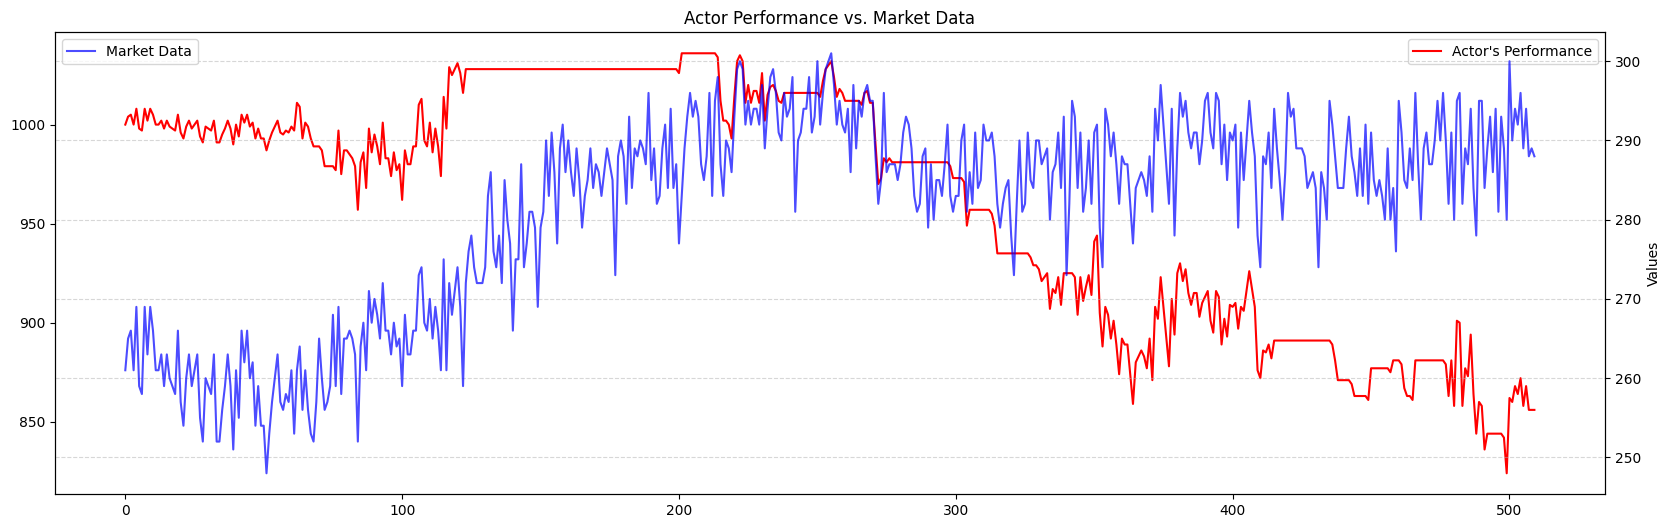

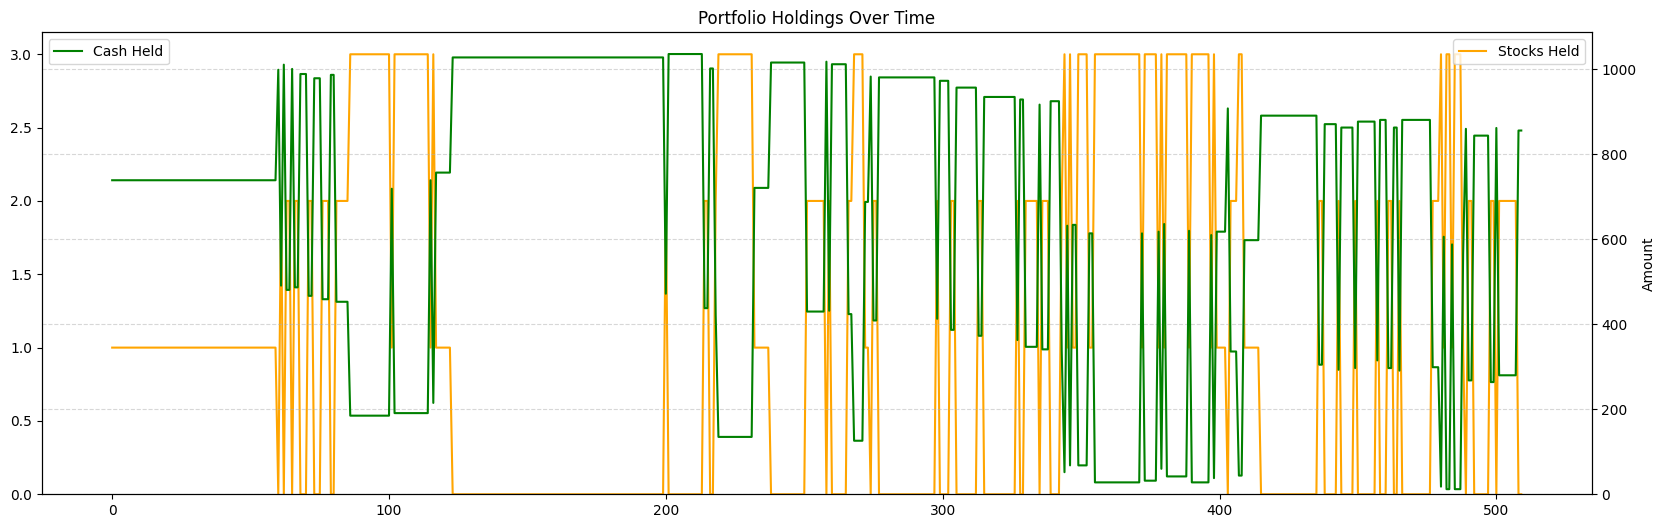

Day 12


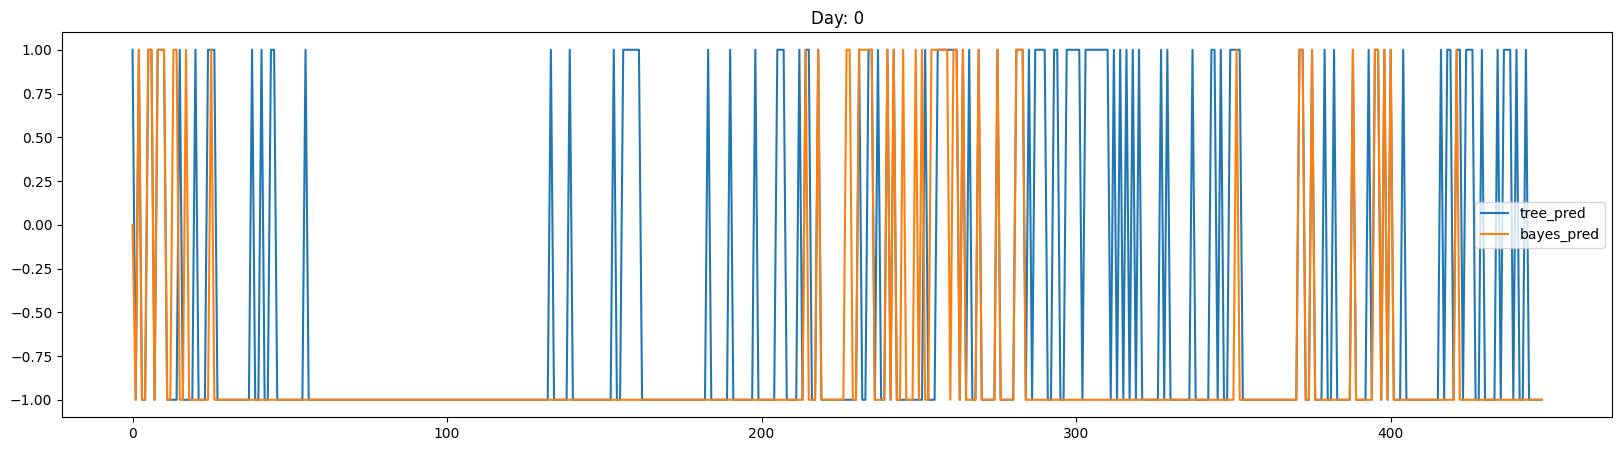

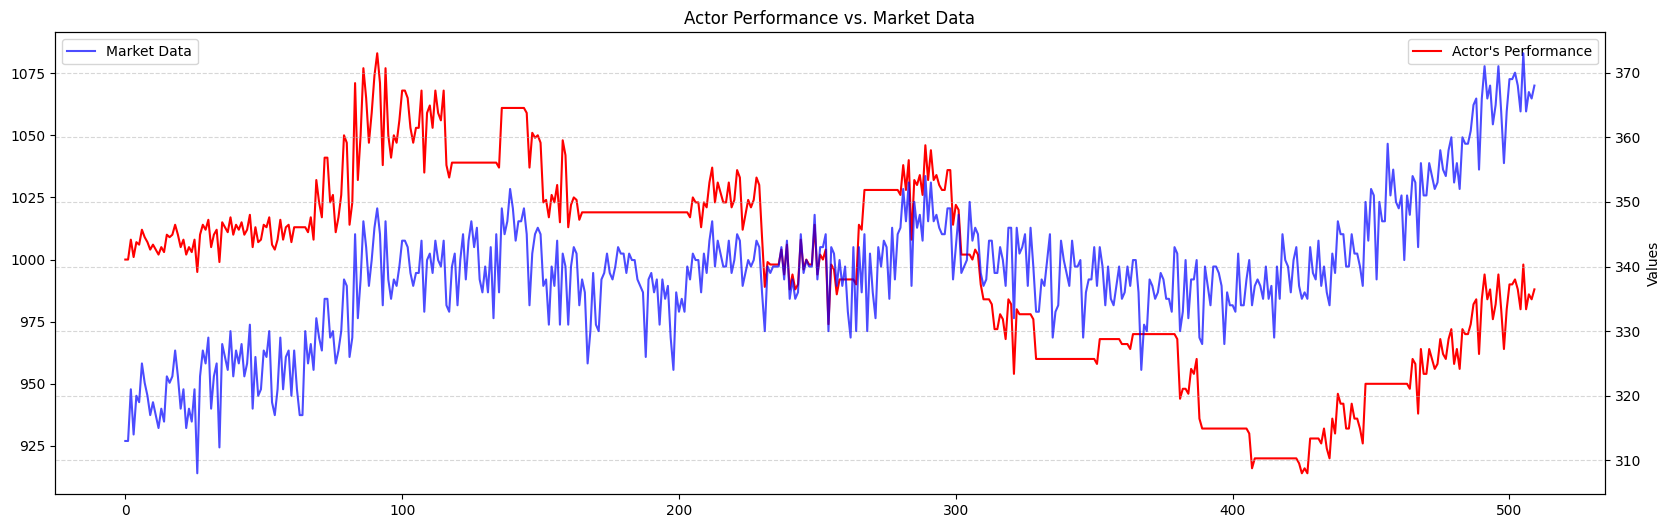

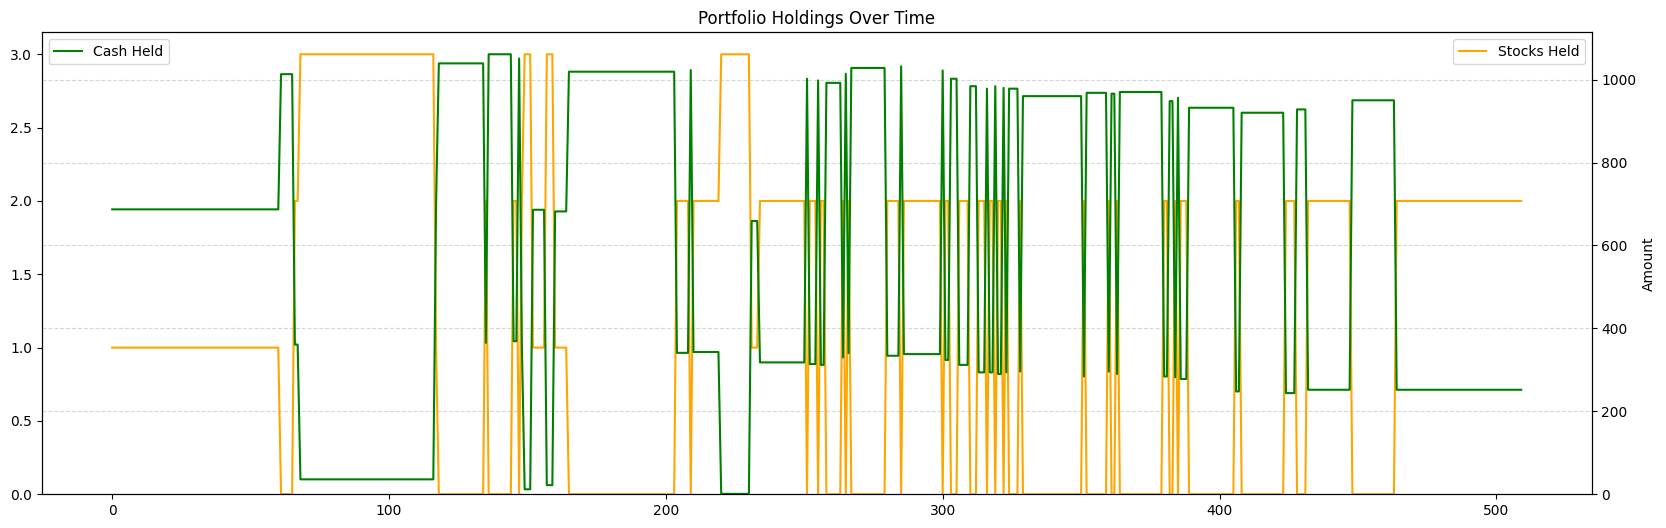

Day 24


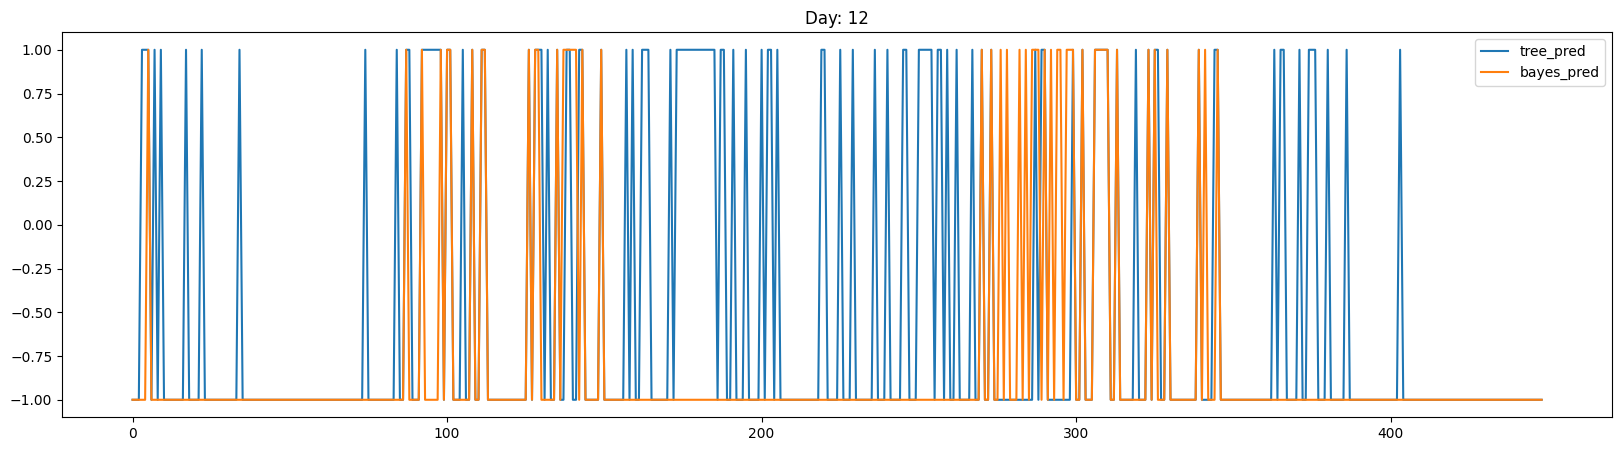

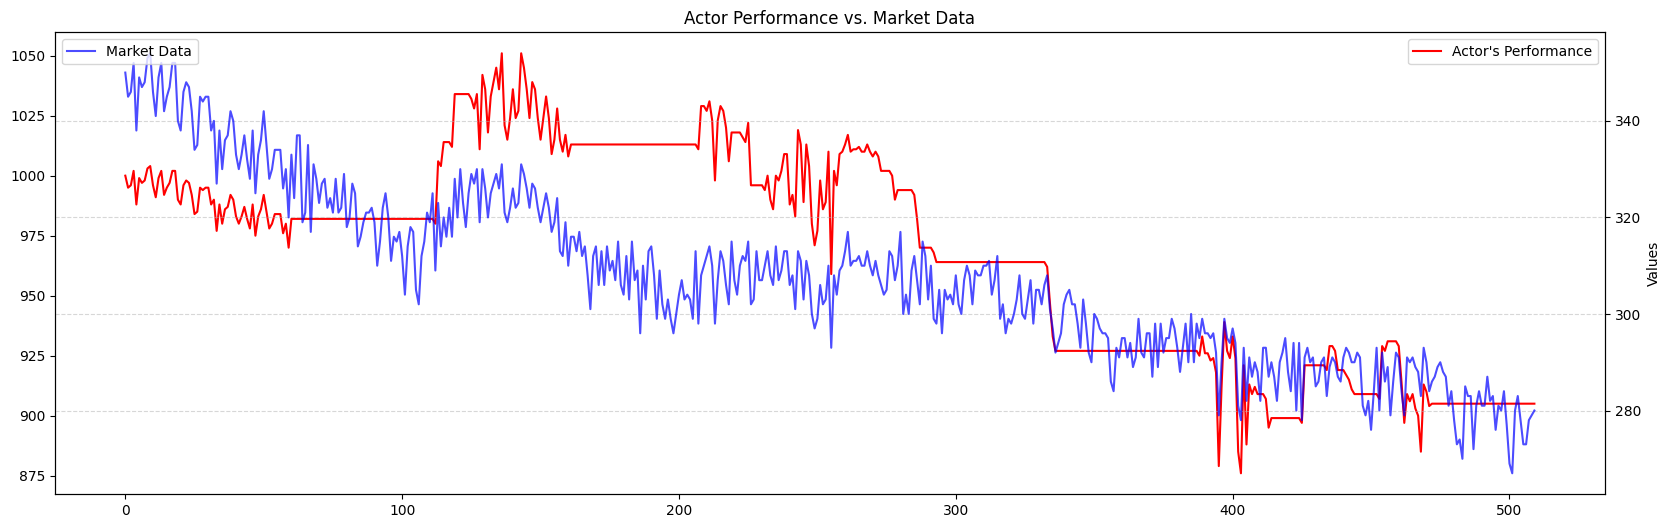

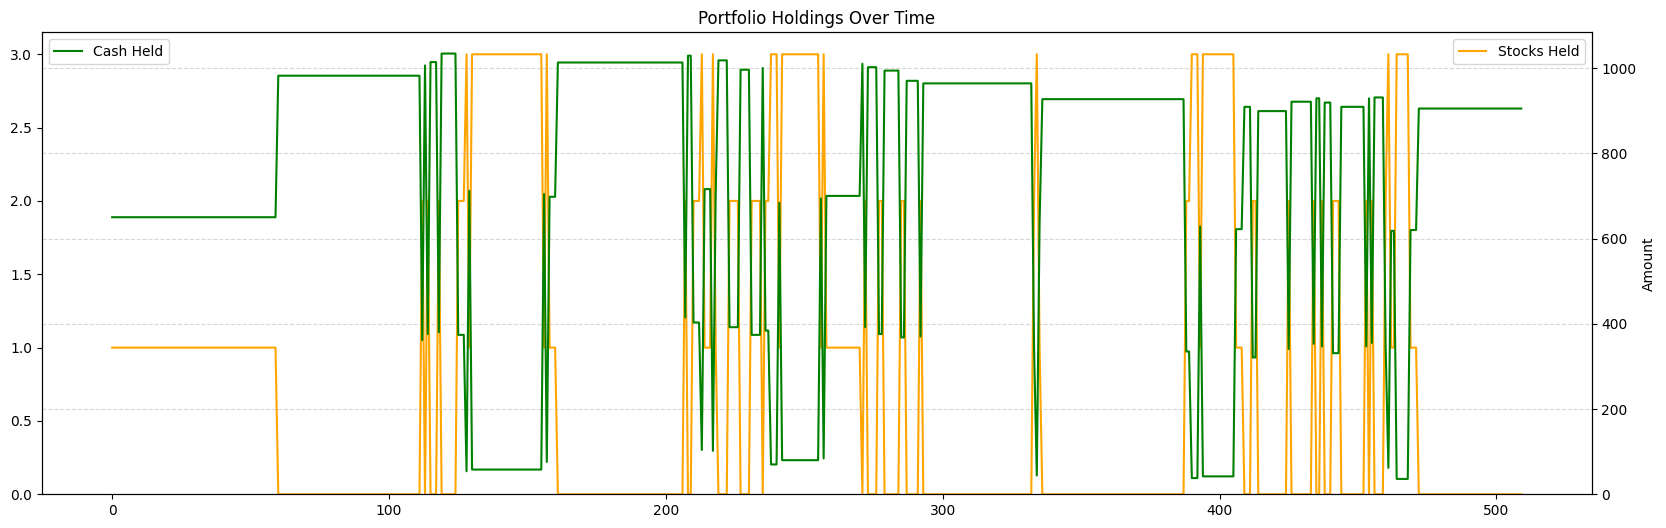

bayes test acc: 0.6066815144766147
tree test acc: 0.6314031180400891
Day 36


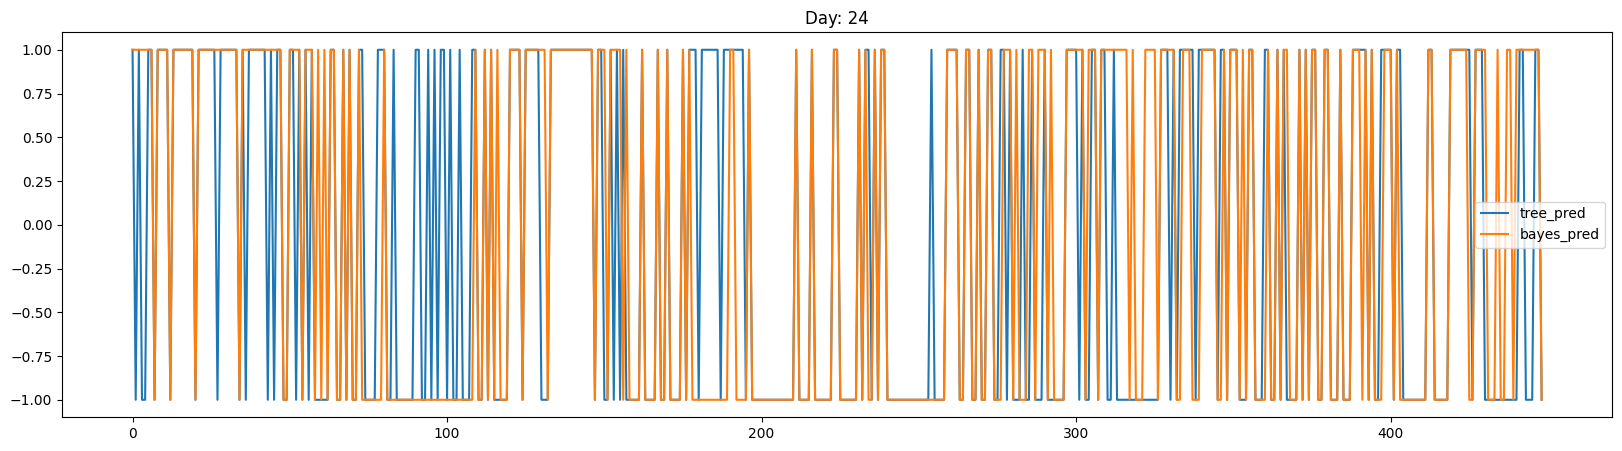

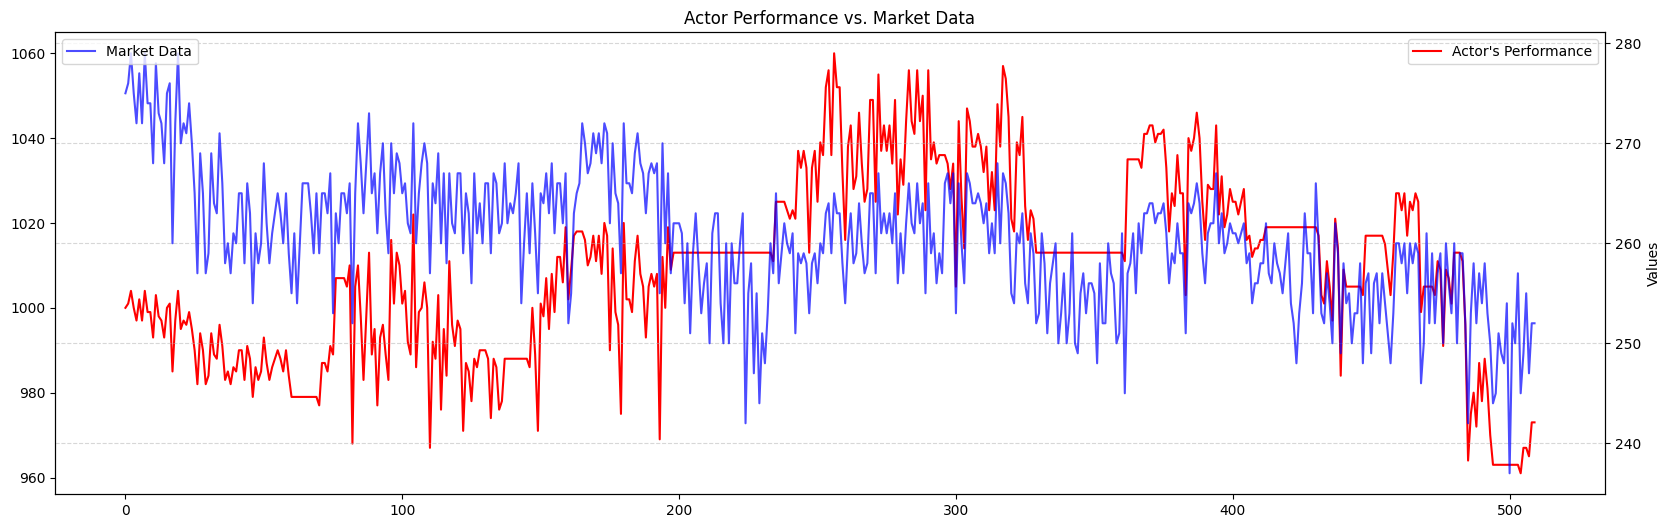

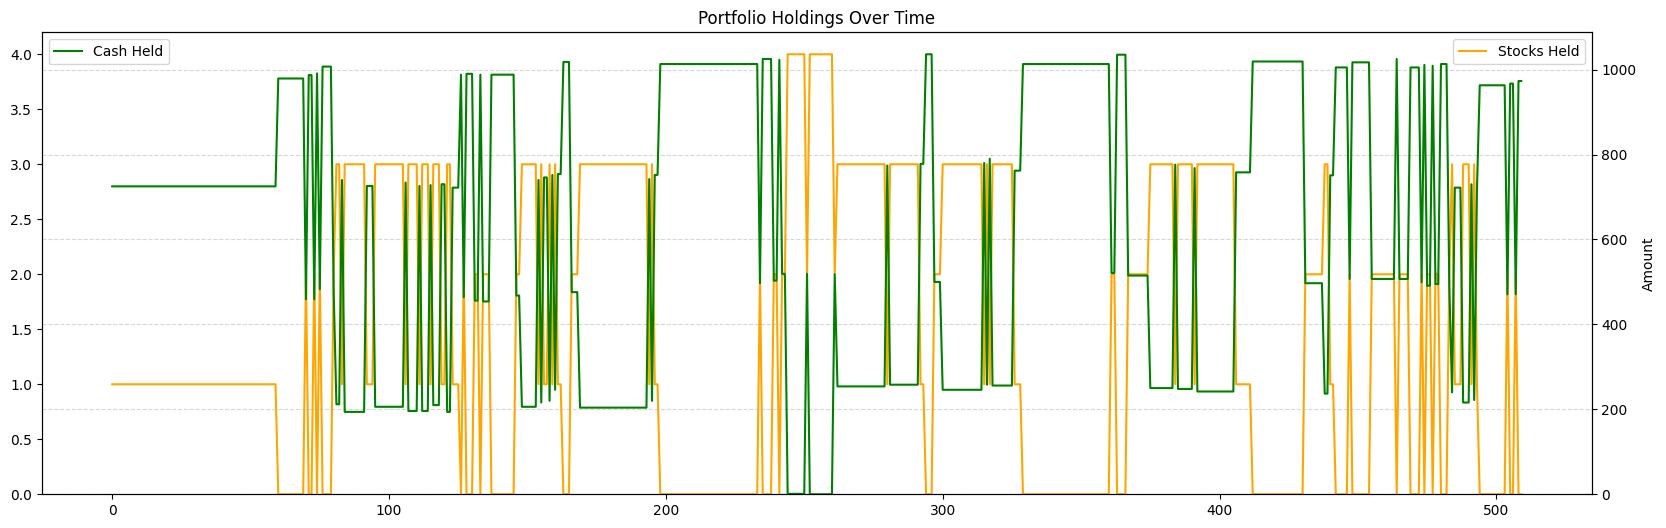

Day 48


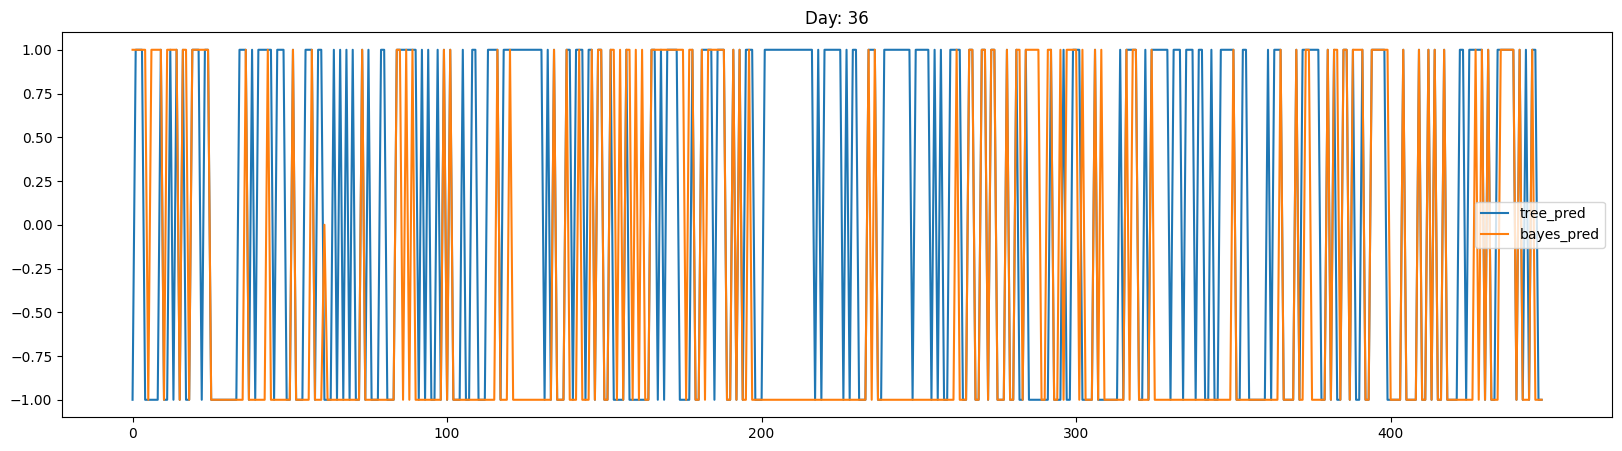

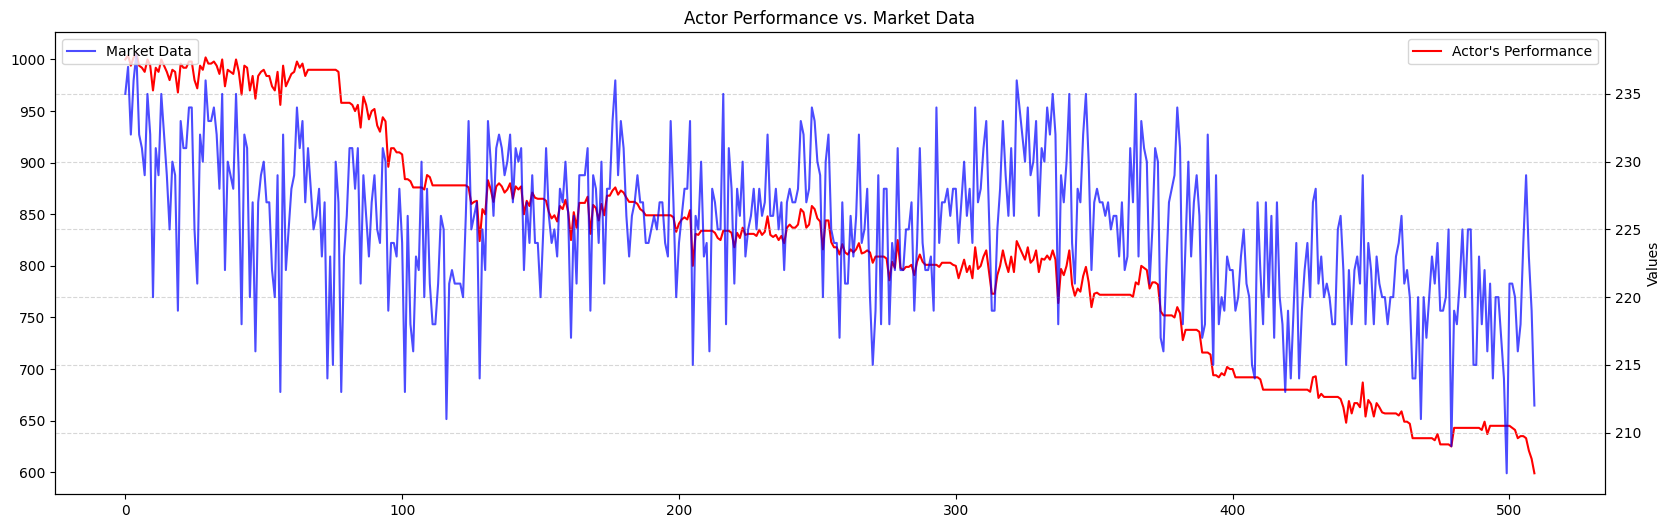

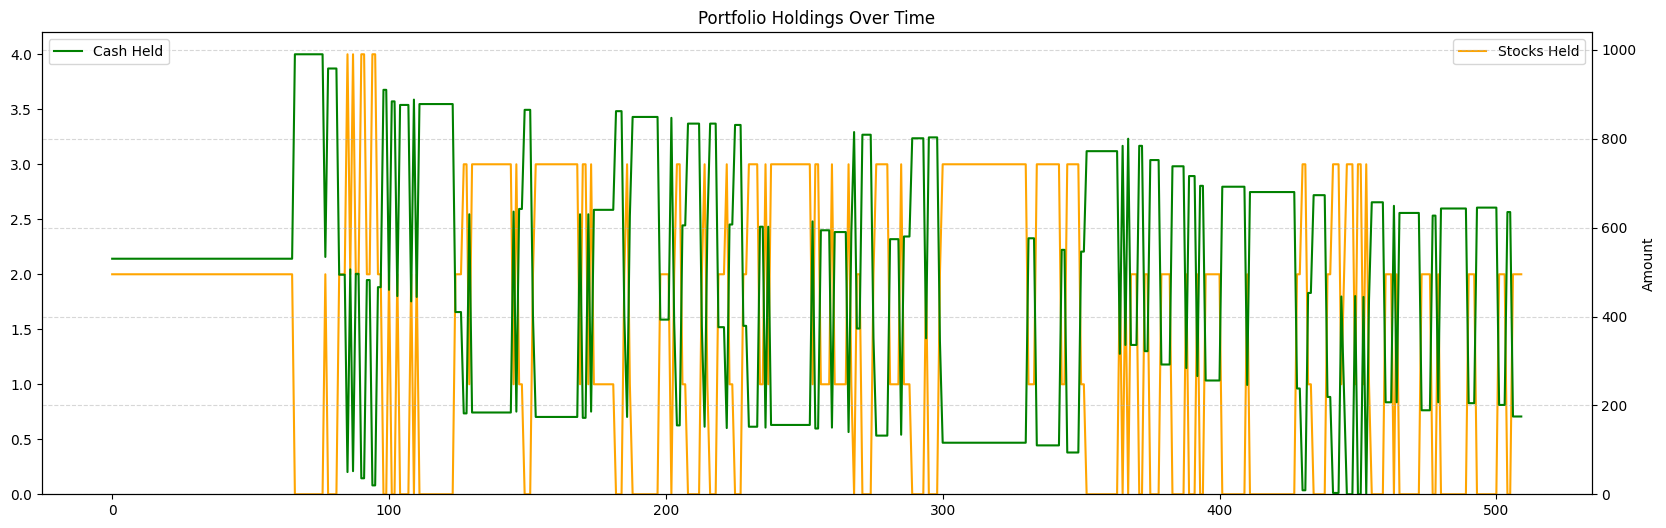

bayes test acc: 0.5854120267260579
tree test acc: 0.6271714922048998
Day 60


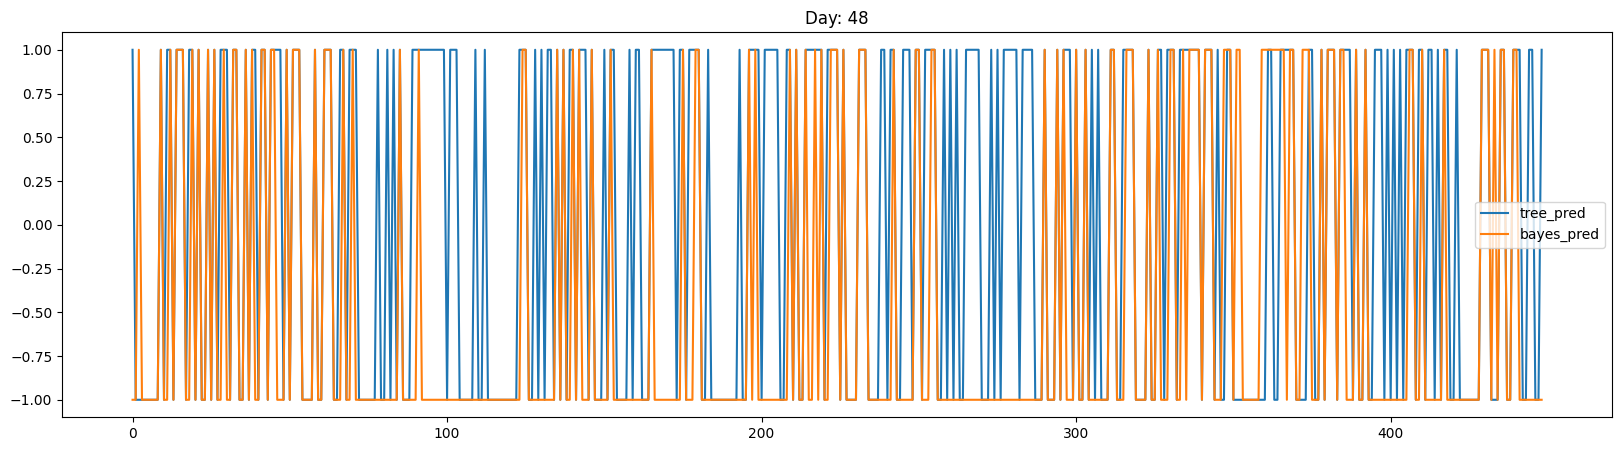

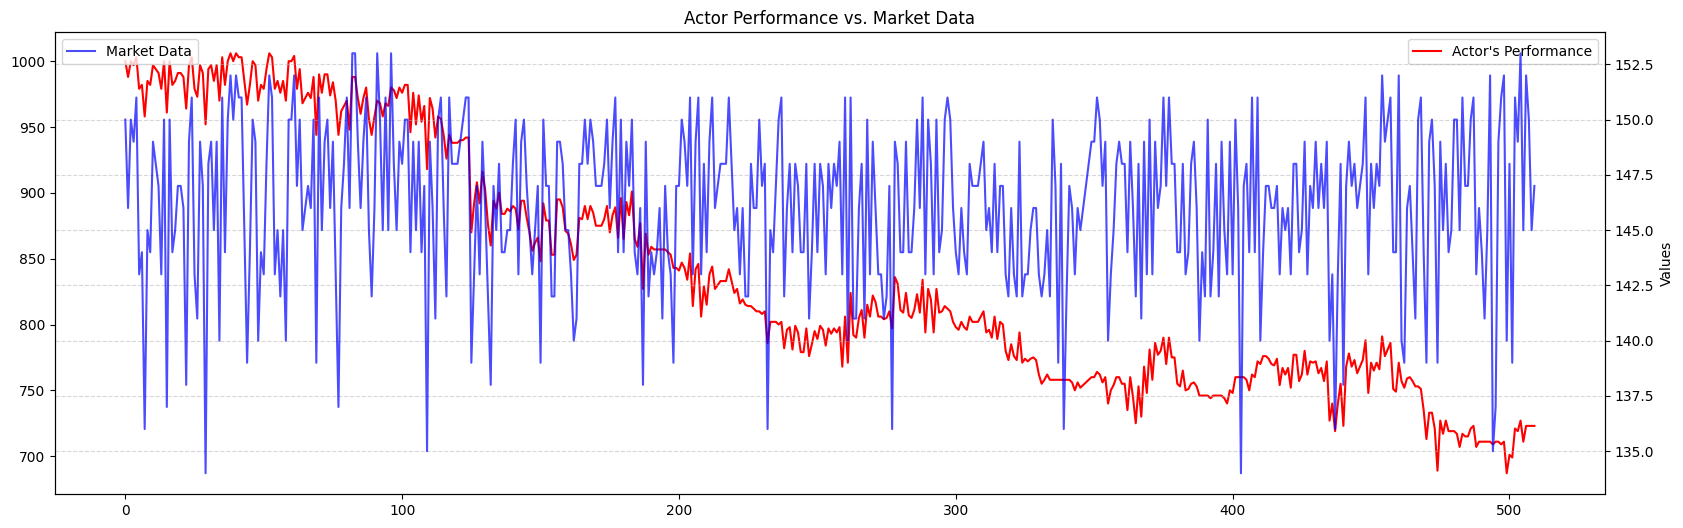

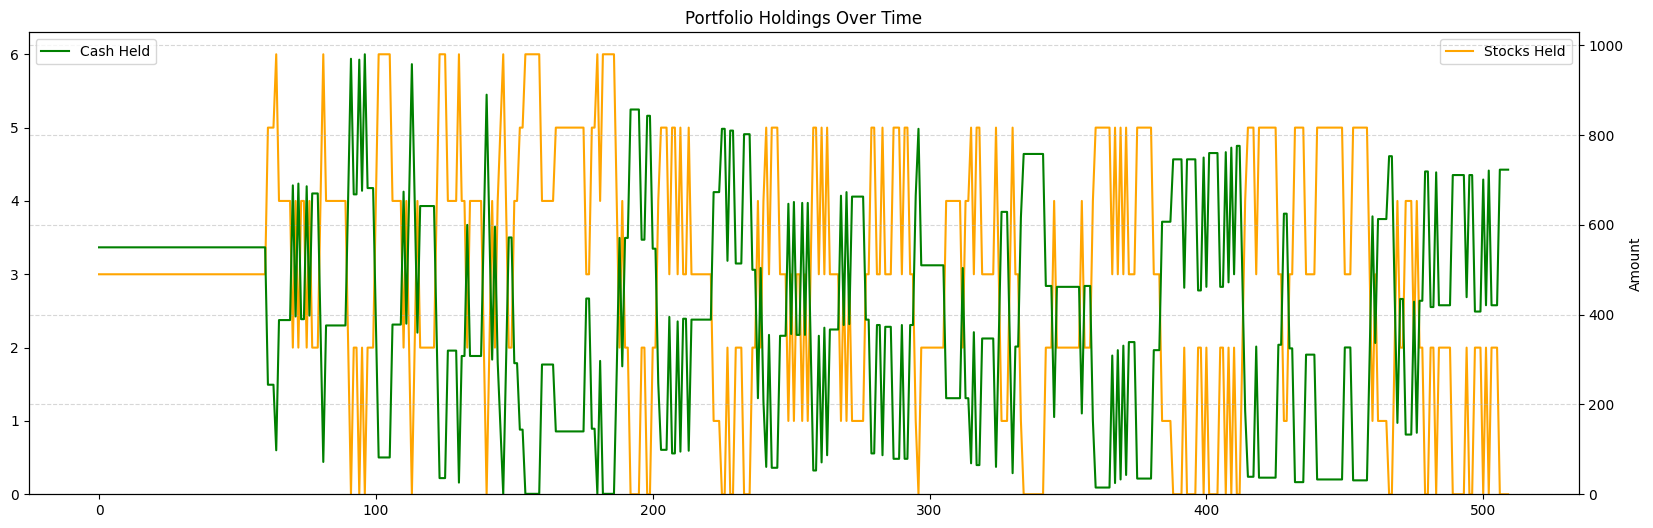

Day 72


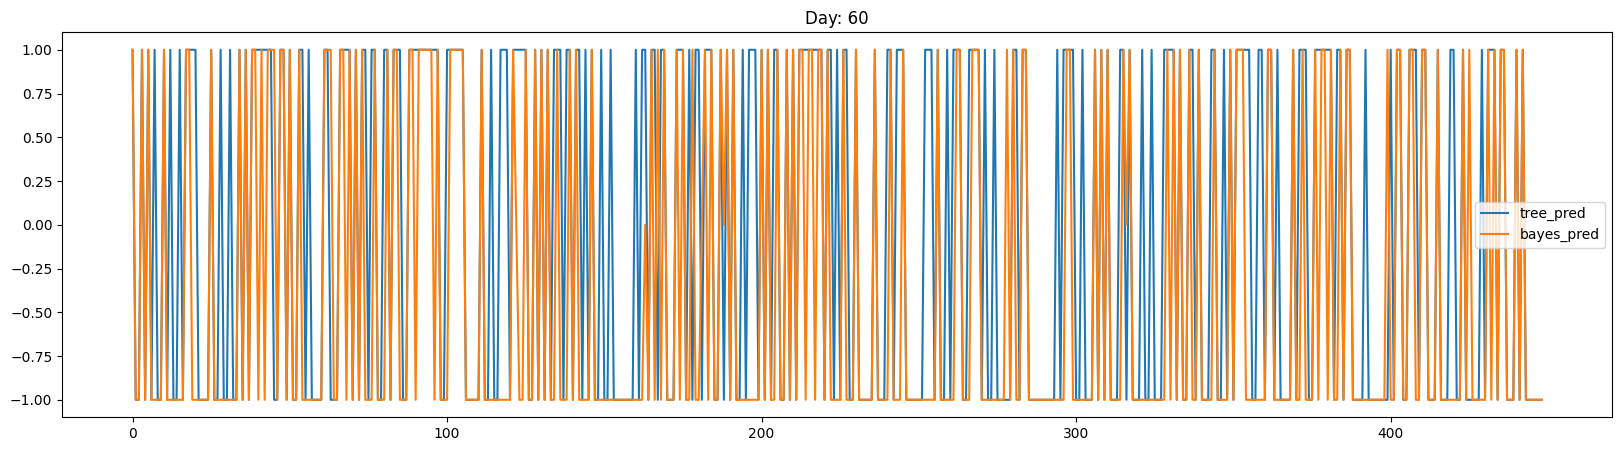

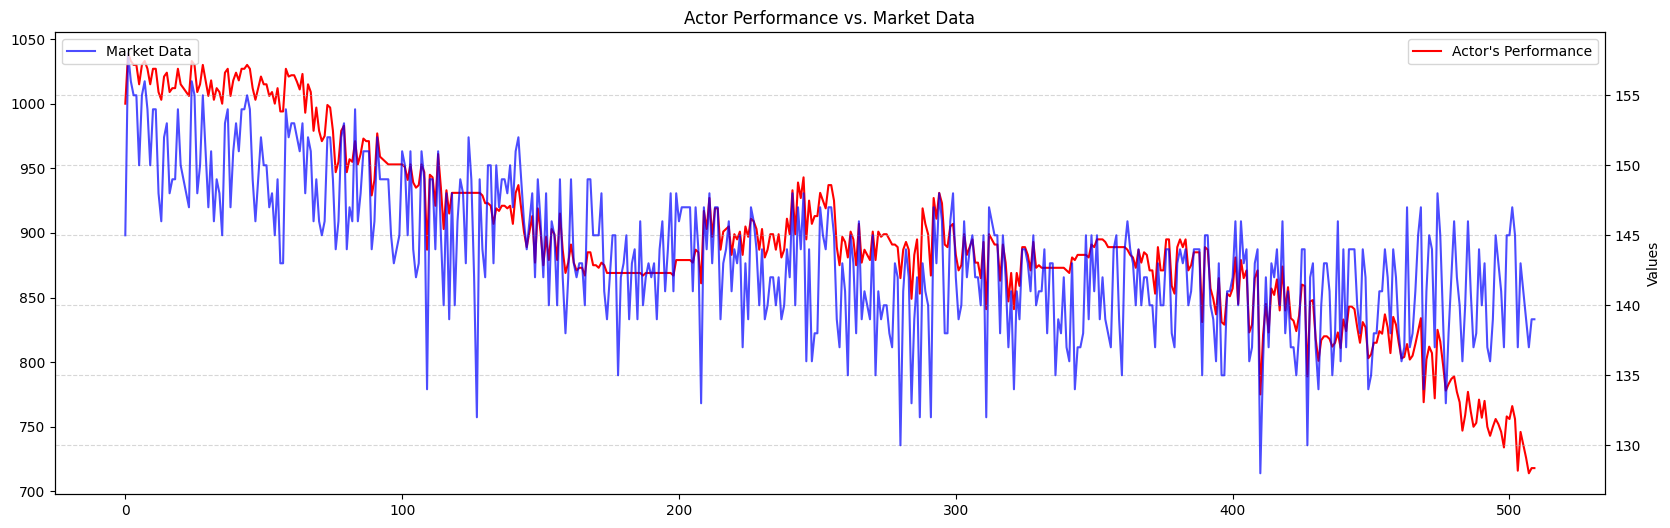

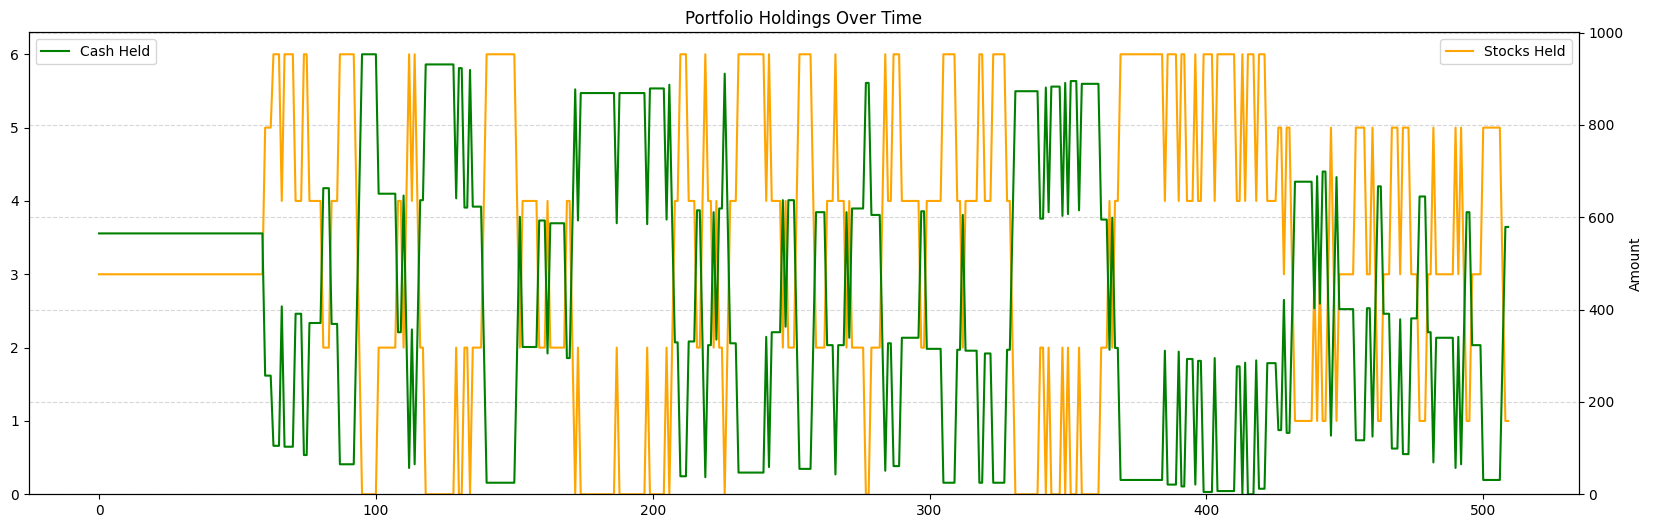

bayes test acc: 0.36102449888641425
tree test acc: 0.6289532293986637
Day 84


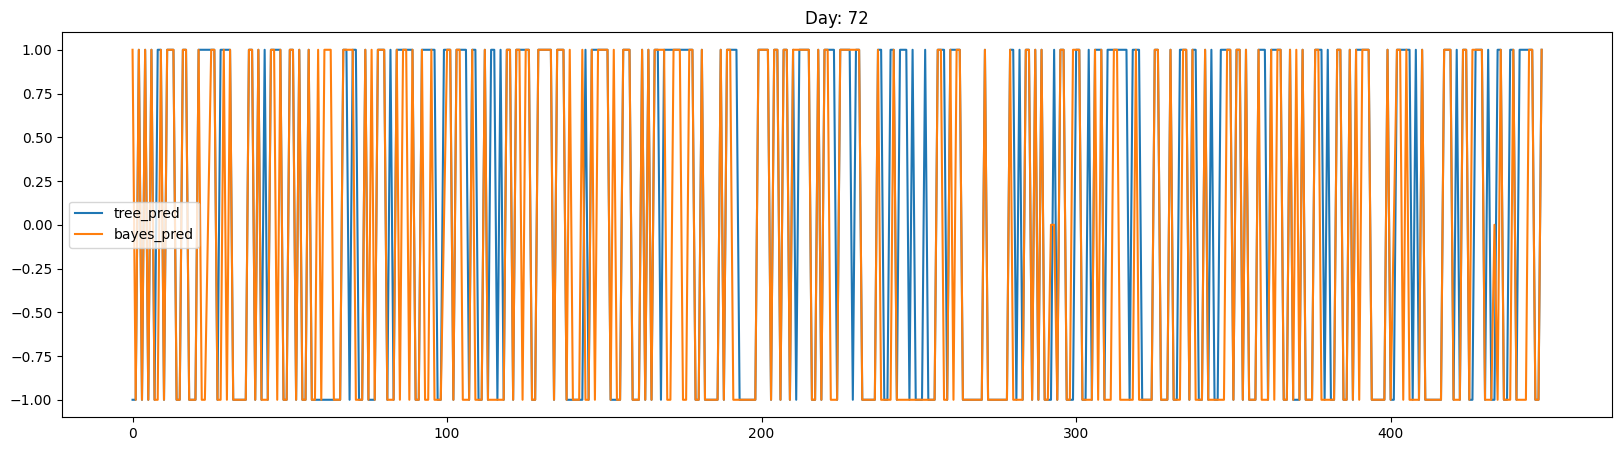

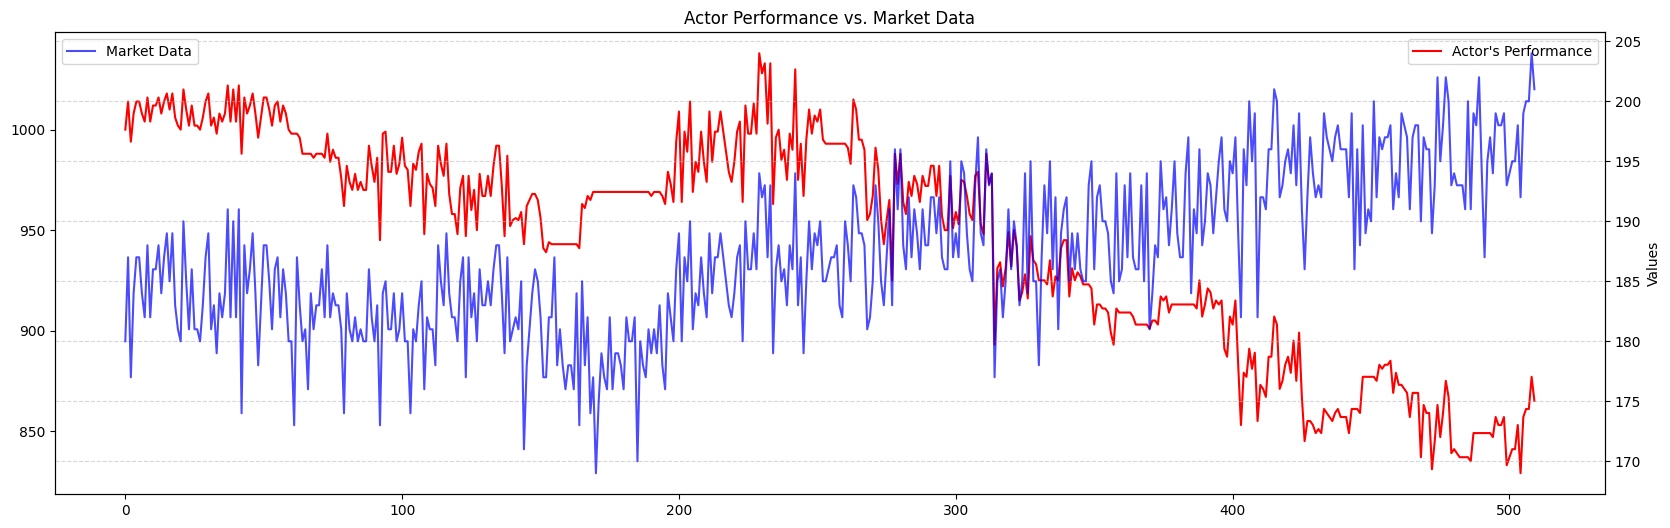

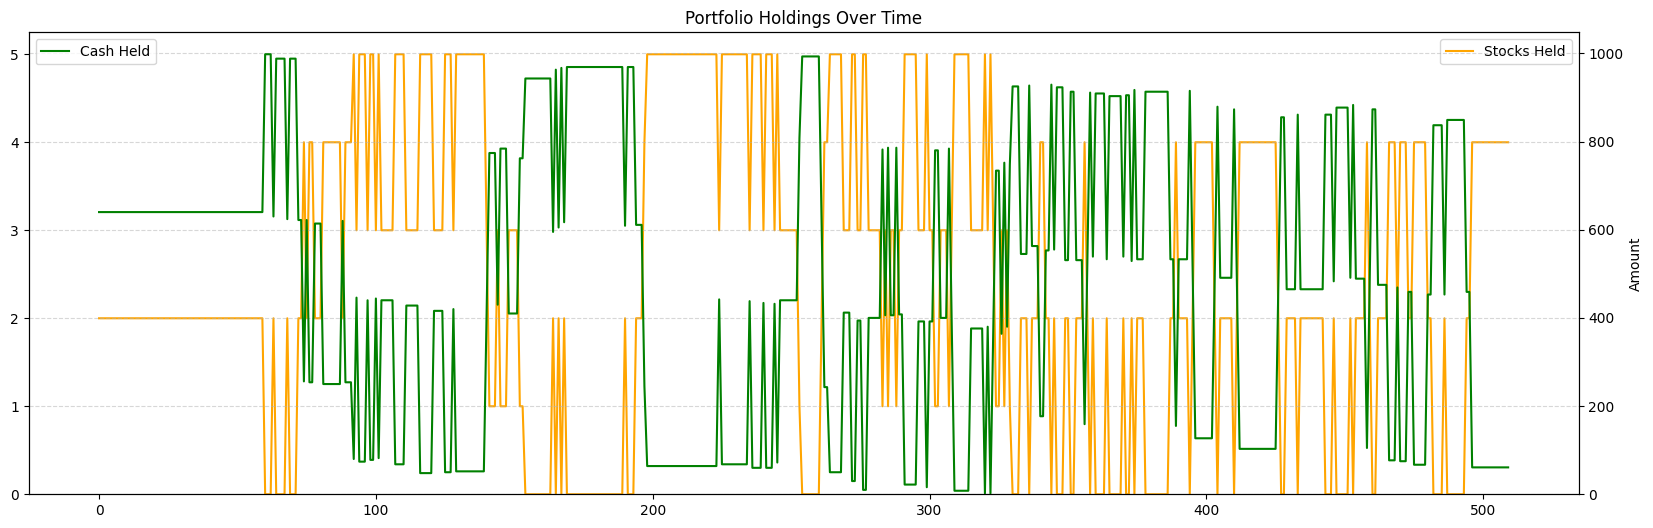

Day 96


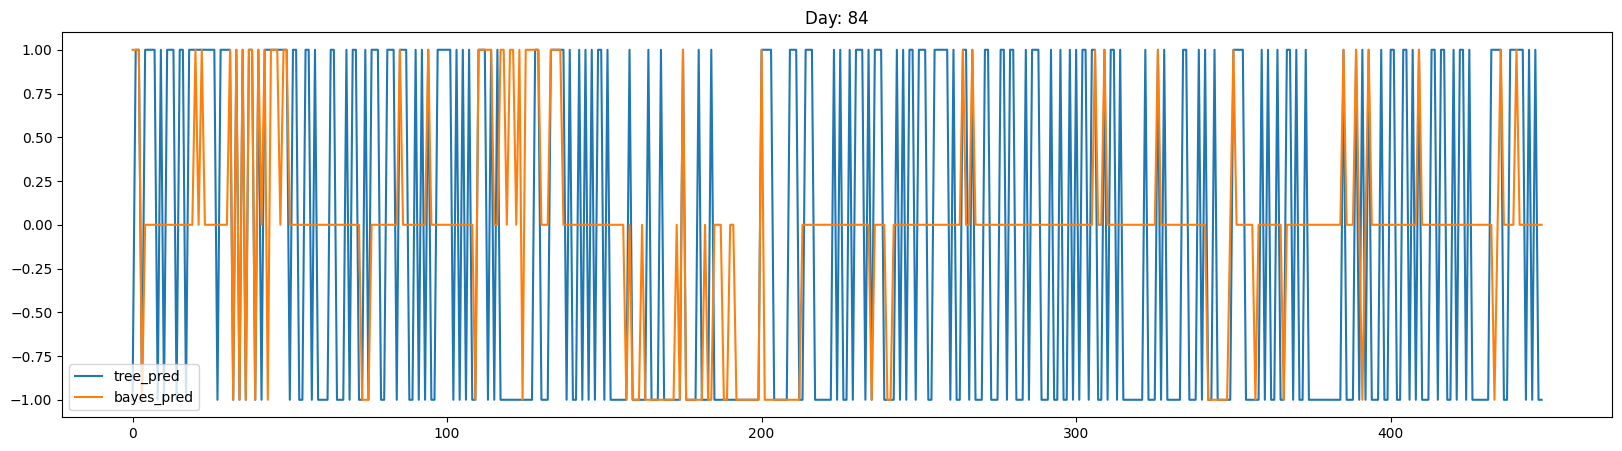

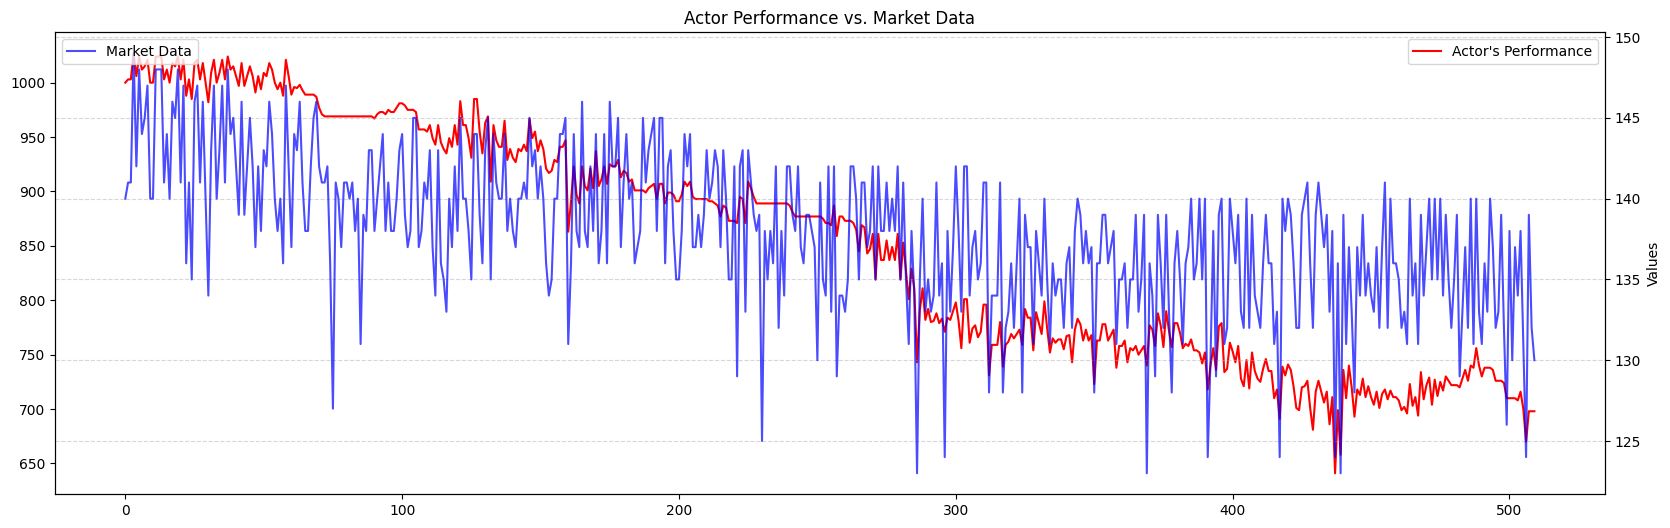

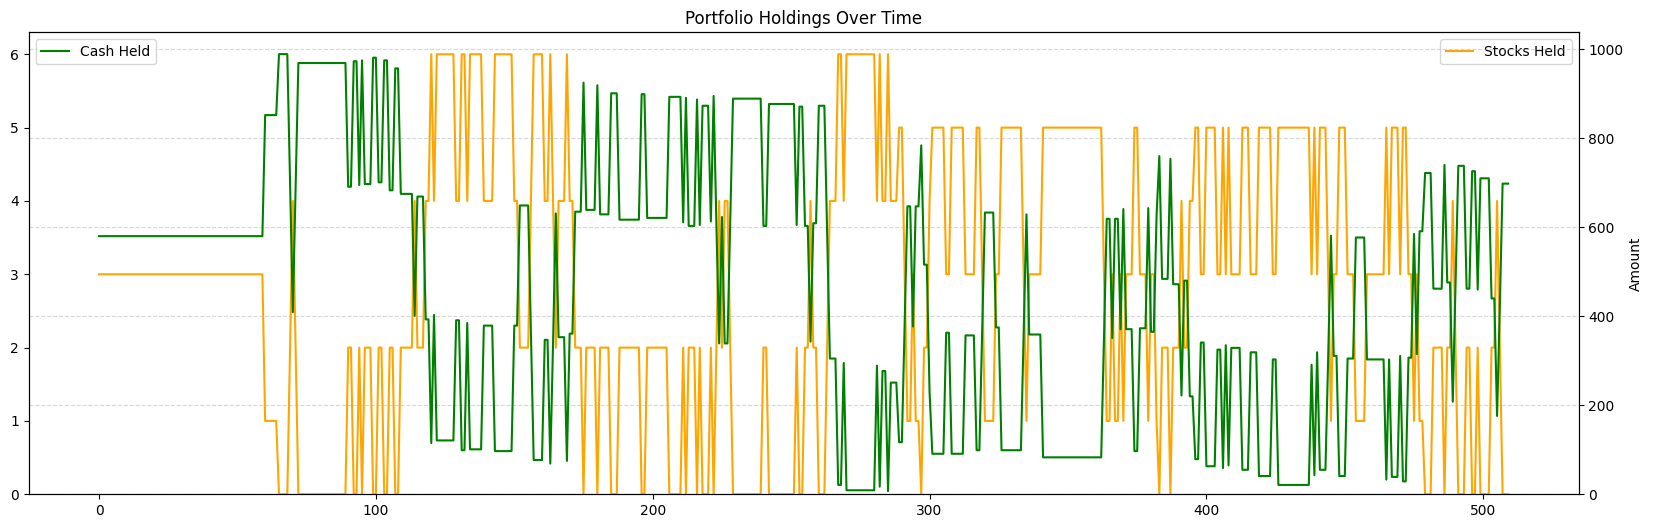

bayes test acc: 0.5935412026726058
tree test acc: 0.6293986636971047
Day 108


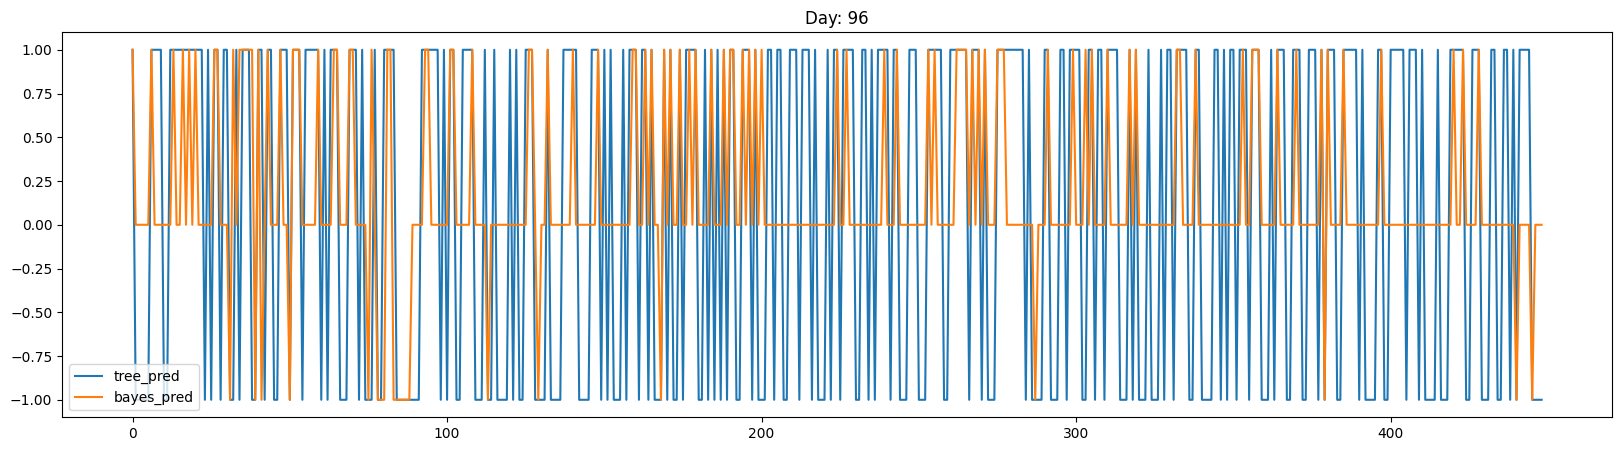

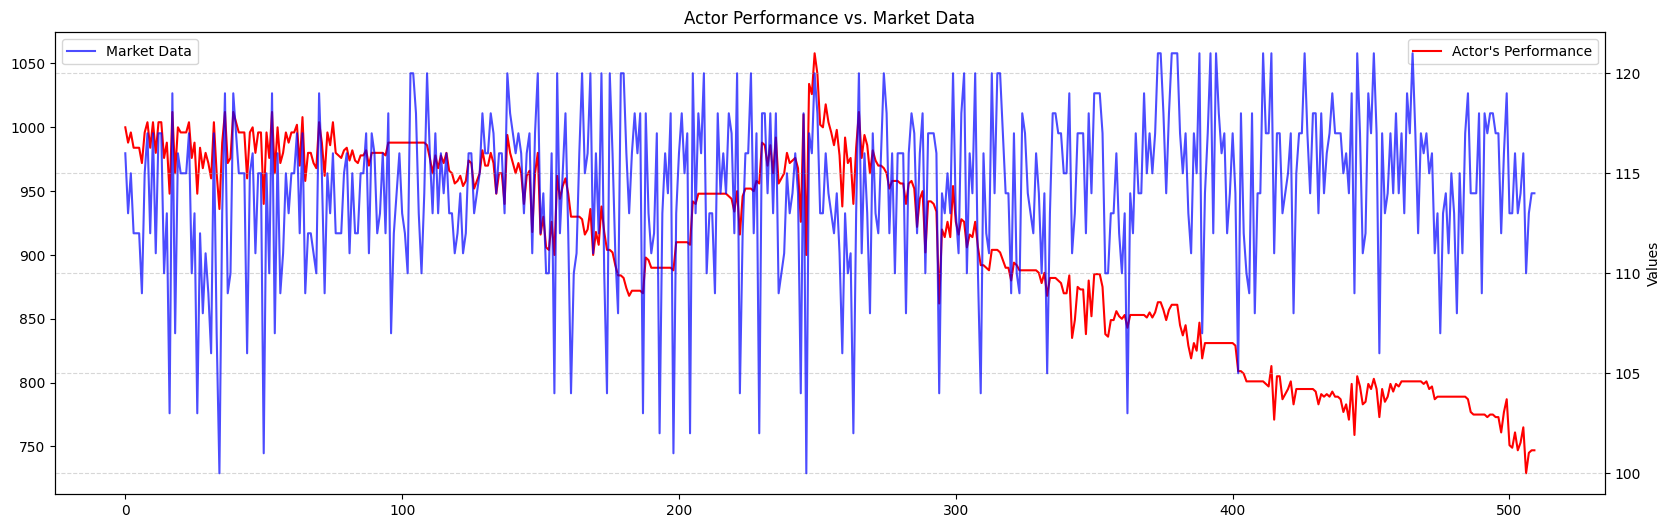

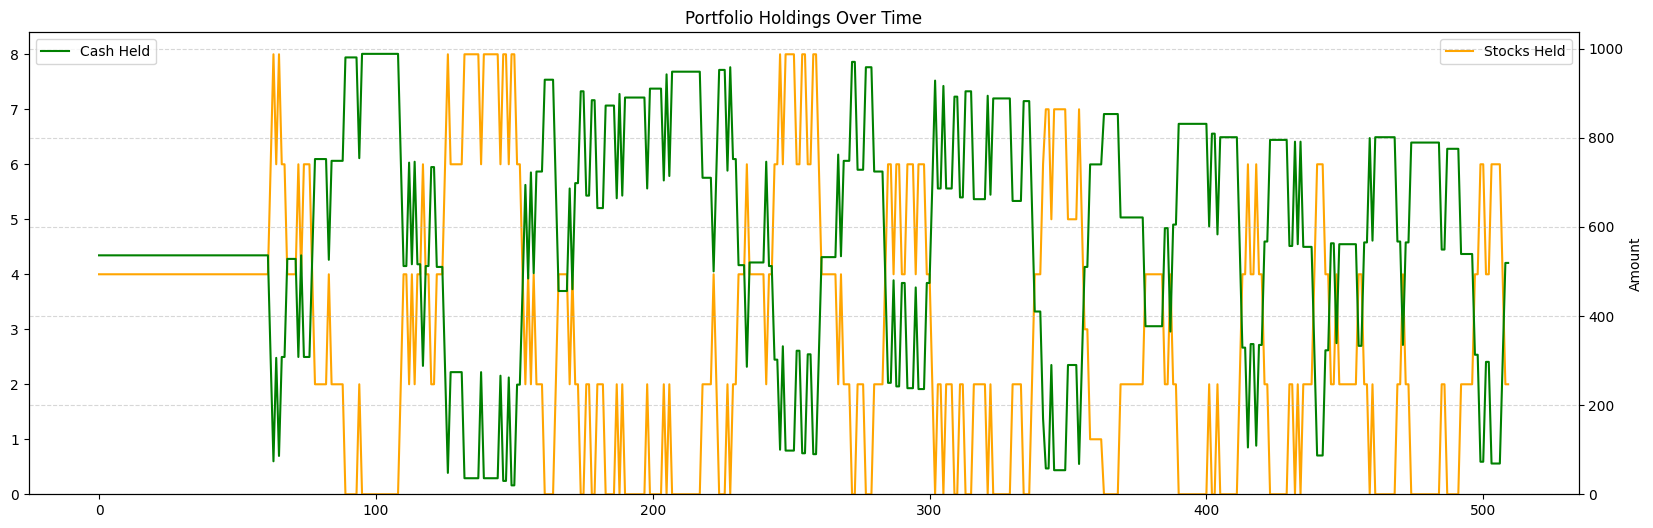

Day 120


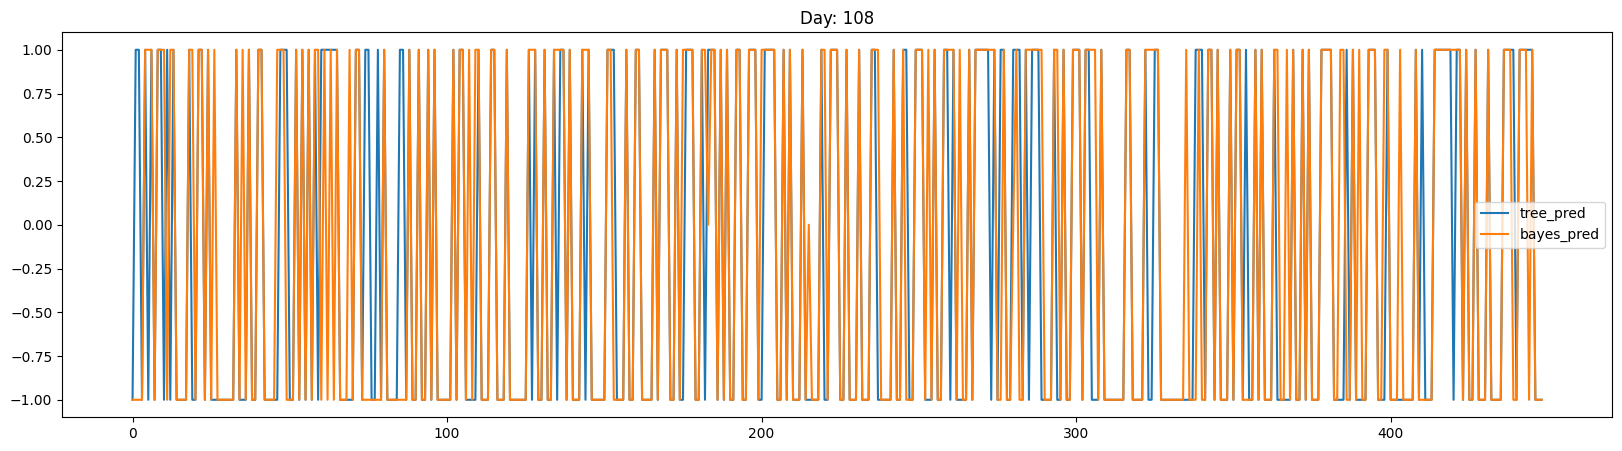

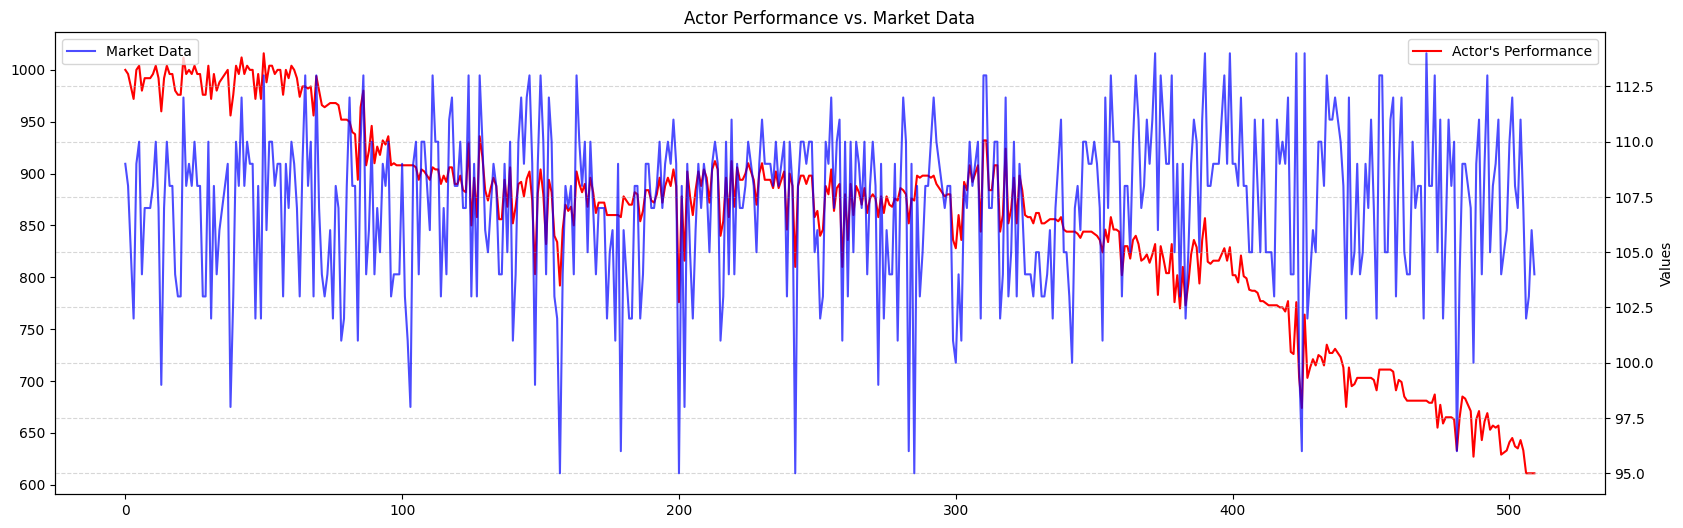

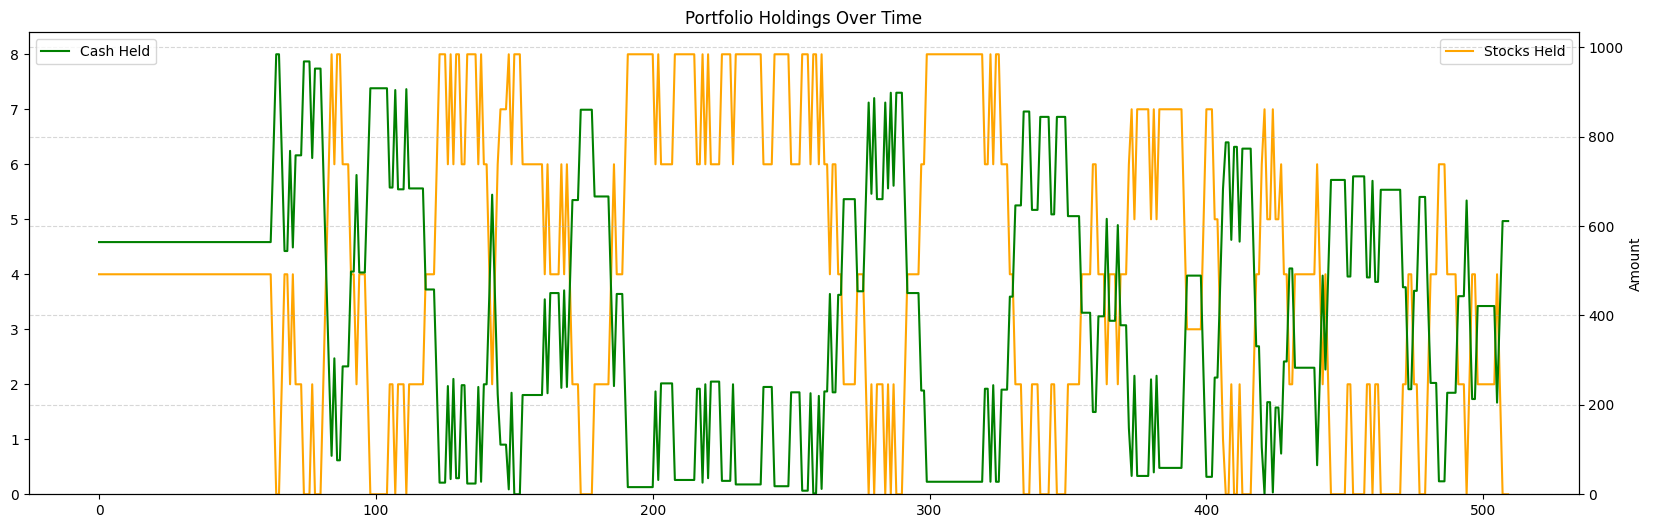

[-0.14404,
 -0.19276000000000004,
 -0.31076000000000004,
 -0.32612,
 -0.33271999999999996]

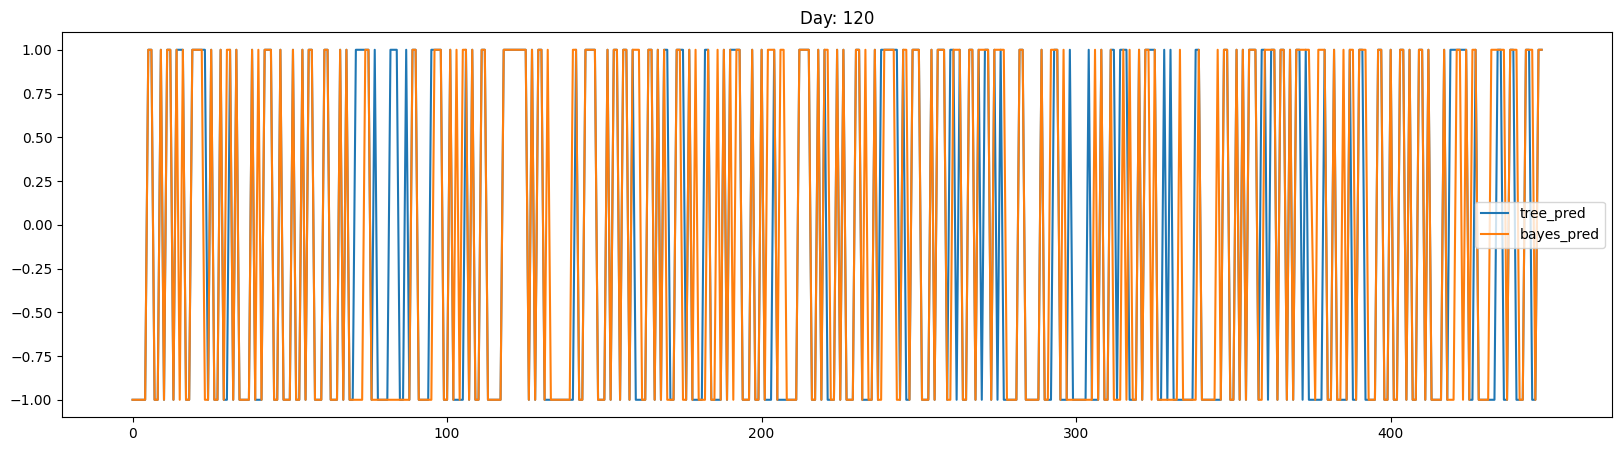

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

@njit
def calculate_rsi(prices, window=14):
    delta = np.diff(prices)
    gain = np.maximum(delta, 0)
    loss = -np.minimum(delta, 0)

    # Calculate rolling means
    gain_roll_mean = np.convolve(gain, np.ones(window)/window, mode='valid')
    loss_roll_mean = np.convolve(loss, np.ones(window)/window, mode='valid')

    # Calculate relative strength (RS)
    rs = gain_roll_mean / loss_roll_mean

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs)) 
    return rsi[-1]

cv_scores = []
for train_data, test_data, test_indicies in generate_folds(tapes_data):
    train_model_data = sixty_df[~sixty_df["day_index"].isin(list(test_indicies))]
    test_model_data = sixty_df[sixty_df["day_index"].isin(list(test_indicies))]

    X = train_model_data.drop(columns=["index", "y1", "day_index"])
    y = train_model_data["y1"]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    #clf = DecisionTreeClassifier(max_leaf_nodes=21)
    #clf = RandomForestClassifier(max_depth=3)
    #clf = SVC()
    bayes = GaussianNB()
    bayes.fit(X_train, y_train)
    tree = DecisionTreeClassifier(max_leaf_nodes=21)
    tree.fit(X_train,y_train)

    print("bayes test acc:", accuracy_score(bayes.predict(X_test), y_test))
    print("tree test acc:", accuracy_score(tree.predict(X_test), y_test))

    bayes.fit(X,y)
    tree.fit(X,y)

    def tree_actor(current_data, current_cash, current_stocks):
        time = len(current_data)
        if time < 60 or time == 509:
            return 0

        window = 60
        ma = np.mean(current_data[-window:-1])
        ma_pred = (ma > current_data[-1])
        rsi = calculate_rsi(current_data)

        tree_pred = tree_predictions[time - 61]
        bayes_pred = bayes_predictions[time - 61]

        rsi_val = 0
        if rsi < 30:
            rsi_val = 1
        elif rsi > 70:
            rsi_val = -1

        if ma_pred:
            ma_val = 1
        else:
            ma_val = -1
        return tree_pred - ma_val

    scores = []
    for i, data in enumerate(test_data):
        day = test_indicies[i]
        test_lob_data = test_model_data[test_model_data["day_index"] == day]
        tree_predictions = tree.predict(test_lob_data.drop(columns=["index", "y1", "day_index"]))
        bayes_predictions = bayes.predict(test_lob_data.drop(columns=["index", "y1", "day_index"]))
        results = broker(tree_actor, data, 1_000, commission=0.002)
        if day % 12 == 0:
            print("Day", day)
            display_results(results, data)
            plt.figure(figsize=(20,5))
            plt.plot(tree_predictions, label ="tree_pred")
            plt.plot(bayes_predictions, label ="bayes_pred")
            plt.legend()
            plt.title(f"Day: {day}")
        scores.append(results[-1])

    cv_scores.append(np.mean(scores))

cv_scores

In [56]:
X = sixty_df.drop(columns=["index", "y1", "day_index"])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert target labels to one-hot encoding
y = tf.keras.utils.to_categorical(sixty_df["y1"].to_numpy(), num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, sixty_df["y1"].to_numpy()+1, test_size=0.2, random_state=42)

In [77]:
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    
    # Hidden layers
    tf.keras.layers.Dense(4, activation='relu'),
    
    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')  # 3 neurons for 3 classes, softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print('Test accuracy (calculated):', accuracy)

Epoch 1/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4961 - loss: 0.9114 - val_accuracy: 0.5893 - val_loss: 0.8479
Epoch 2/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5899 - loss: 0.8257 - val_accuracy: 0.5661 - val_loss: 0.8279
Epoch 3/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6111 - loss: 0.8018 - val_accuracy: 0.6281 - val_loss: 0.8048
Epoch 4/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6232 - loss: 0.7847 - val_accuracy: 0.6178 - val_loss: 0.7895
Epoch 5/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6286 - loss: 0.7705 - val_accuracy: 0.6236 - val_loss: 0.7830
Epoch 6/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6332 - loss: 0.7658 - val_accuracy: 0.6122 - val_loss: 0.7823
Epoch 7/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6262 - loss: 0.7721 - val_accuracy: 0.6336 - val_loss: 0.7780
Epoch 8/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6342 - loss: 0.7620 - 

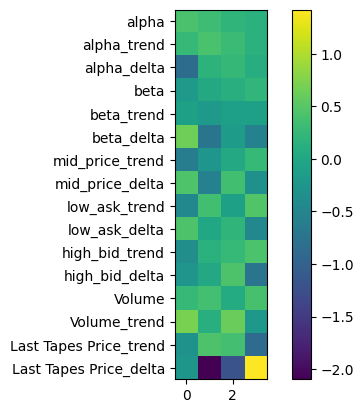

In [78]:
plt.imshow(model.weights[0])
plt.yticks(np.arange(len(list(X))), list(X))
plt.colorbar()

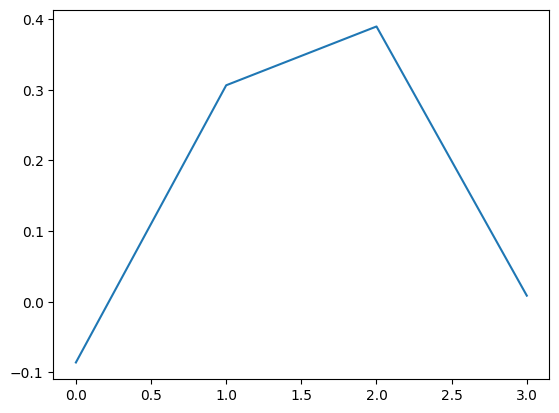

In [90]:
plt.plot(model.weights[1])

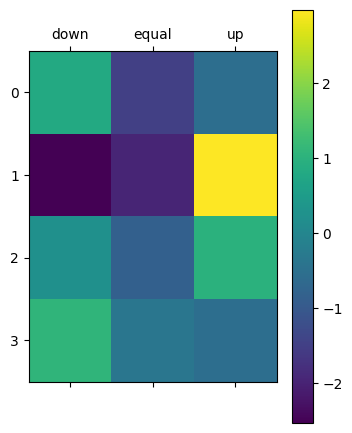

In [89]:
plt.matshow(model.weights[2])
plt.xticks(np.arange(3), ["down", "equal", "up"])
plt.colorbar()